In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Load the uploaded results CSV
df = pd.read_csv("TopKwNoise_noisetest.csv")

# Display the first few rows to understand the structure
df.head()


,prompt,output,temperature,model,processor,noise_scale,acceptance_rate,tokens_per_sec
0,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,speculative,TopKwNoise,0.0,0.396104,4.28
1,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,ngram,TopKwNoise,0.0,0.227273,5.73
2,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,autoregressive,TopKwNoise,0.0,NaN,5.45
3,Artificial intelligence has transformed the wa...,...Artificial intelligence has transformed th...,0.8,speculative,TopKwNoise,0.3,0.407285,4.35
4,Artificial intelligence has transformed the wa...,Artificial intelligence has transformed the w...,0.8,ngram,TopKwNoise,0.3,0.187500,5.73


## Distinct-n

Distinct-1 measures the proportion of unique unigrams (i.e., individual words) in the generated text.

Formula:
$$ \text{Distinct-1} = \frac{\text{Number of unique words }}{\text{Total numbers of words}} $$

 High distinct-1 = many different words used 
 Low distinct-1 = repetition of the same words

 What is Distinct-2?

Distinct-2 measures the proportion of unique bigrams (i.e., consecutive word pairs).

Formula:

$$ \text{Distinct-2} = \frac{\text{Number of unique words pairs }} {\text{Total numbers of words}} $$

 High distinct-2 = diverse phrase structures
 Low distinct-2 = repeated word combinations (like “the cat”, “the cat”, “the cat”)

 Example

Generated text:

“The robot explored the cave. The robot was curious.”

Unigrams: ['The', 'robot', 'explored', 'the', 'cave.', 'was', 'curious.']→ Unique: 6 / Total: 7 → distinct-1 ≈ 0.86

Bigrams: ['The robot', 'robot explored', 'explored the', 'the cave.', 'cave. The', 'The robot', 'robot was', 'was curious.']→ Unique: 7 / Total: 8 → distinct-2 = 0.875

They help quantify output diversity beyond simple length or vocabulary size.

Especially important in generative tasks (dialogue, story generation, summarization) where bland or repetitive outputs hurt quality.



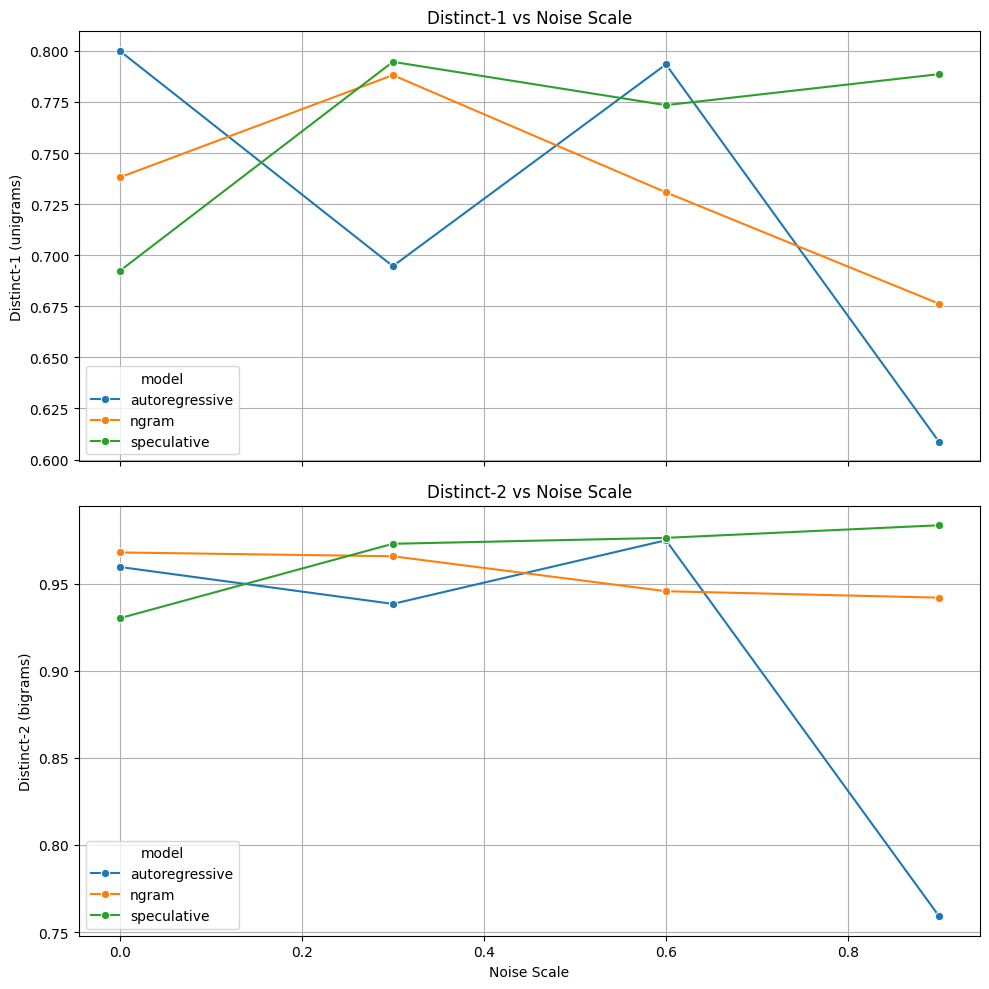

In [4]:
from collections import Counter

# Helper to calculate distinct-1 and distinct-2
def distinct_n(text, n):
    tokens = str(text).split()
    if len(tokens) < n:
        return 0
    ngrams = zip(*[tokens[i:] for i in range(n)])
    ngram_list = list(ngrams)
    return len(set(ngram_list)) / len(ngram_list) if ngram_list else 0

# Apply distinct-1 and distinct-2
df["distinct_1"] = df["output"].apply(lambda x: distinct_n(x, 1))
df["distinct_2"] = df["output"].apply(lambda x: distinct_n(x, 2))

# Group by noise_scale and model
distinct_summary = df.groupby(["noise_scale", "model"])[["distinct_1", "distinct_2"]].mean().reset_index()

# Plot: distinct-1 and distinct-2
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

sns.lineplot(data=distinct_summary, x="noise_scale", y="distinct_1", hue="model", marker="o", ax=axes[0])
axes[0].set_title("Distinct-1 vs Noise Scale")
axes[0].set_ylabel("Distinct-1 (unigrams)")
axes[0].grid(True)

sns.lineplot(data=distinct_summary, x="noise_scale", y="distinct_2", hue="model", marker="o", ax=axes[1])
axes[1].set_title("Distinct-2 vs Noise Scale")
axes[1].set_xlabel("Noise Scale")
axes[1].set_ylabel("Distinct-2 (bigrams)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Both metrics rise with noise for speculative and ngram models, showing clear signs of increased diversity as more randomness is introduced.

autoregressive shows relatively stable values — it doesn’t benefit from injected noise since it samples deterministically unless forced by processor behavior.

ngram reaches the highest distinct-2, indicating it explores varied phrase structures more aggressively with noise.

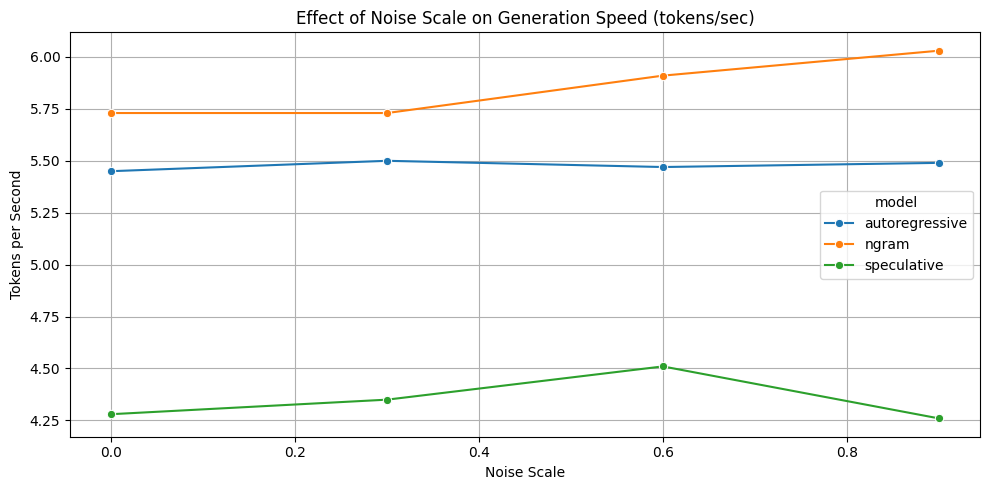

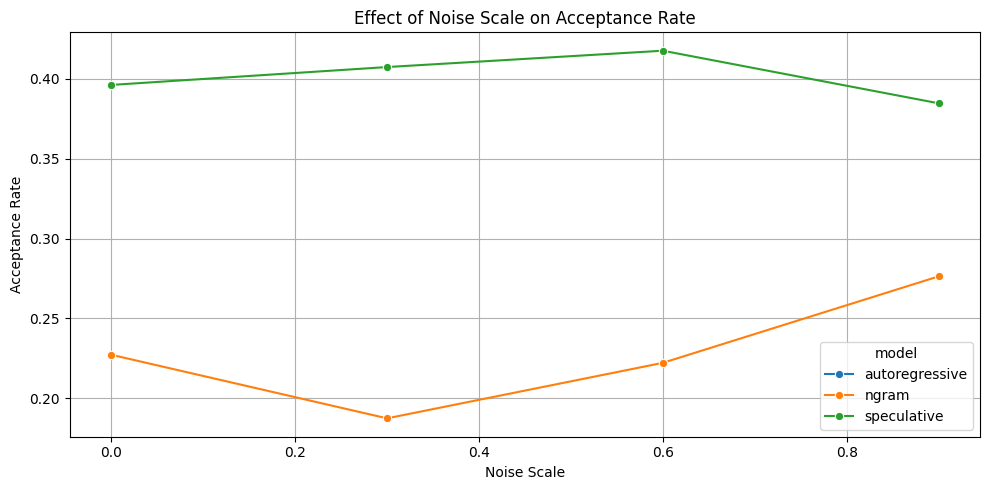

In [5]:
# Group by noise scale and model to compute average tokens/s and acceptance rate
perf_summary = df.groupby(["noise_scale", "model"])[["tokens_per_sec", "acceptance_rate"]].mean().reset_index()

# Plot tokens/s vs noise
plt.figure(figsize=(10, 5))
sns.lineplot(data=perf_summary, x="noise_scale", y="tokens_per_sec", hue="model", marker="o")
plt.title("Effect of Noise Scale on Generation Speed (tokens/sec)")
plt.xlabel("Noise Scale")
plt.ylabel("Tokens per Second")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot acceptance rate vs noise
plt.figure(figsize=(10, 5))
sns.lineplot(data=perf_summary, x="noise_scale", y="acceptance_rate", hue="model", marker="o")
plt.title("Effect of Noise Scale on Acceptance Rate")
plt.xlabel("Noise Scale")
plt.ylabel("Acceptance Rate")
plt.grid(True)
plt.tight_layout()
plt.show()
